In [1]:
import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.sql import SparkSession
sc = SparkContext("local")
spark = SparkSession.builder.getOrCreate()

# Cluster visualisation

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from adjustText import adjust_text
import numpy as np
from pyspark.ml.feature import PCA as PCAml

def plot_clustering(data,predictions):
    pca = PCAml(k=2, inputCol="features", outputCol="pca")
    pca_model = pca.fit(data)
    pca_transformed = pca_model.transform(data)

    X_pca = pca_transformed.rdd.map(lambda row: row.pca).collect()
    X_pca = np.array(X_pca)
    cluster_assignment = np.array(predictions.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)
    countries = np.array(predictions.rdd.map(lambda row: row.Country).collect())

    pca_data = np.hstack((X_pca,cluster_assignment))
    pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal","cluster_assignment"))
    pca_df['cluster_assignment'] = pca_df['cluster_assignment'].astype(int)

    sns.set(style="whitegrid", rc={'figure.figsize':(16,9)})
    sns.scatterplot(data=pca_df, x="1st_principal", y="2nd_principal", hue="cluster_assignment", palette="tab10").legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

    annotations = []
    for i, point in pca_df.iterrows():
        annotations.append(plt.annotate(countries[i], (point['1st_principal'], point['2nd_principal'])))
    adjust_text(annotations)
    plt.show()

In [3]:
import numpy as np
from pyspark.sql import functions as F
tFile="data\\netflix-subscription.csv"
data = spark.read.csv(tFile,header=True, inferSchema=True)
data.toPandas()

,Country_Code,Country,Total_Library_Size,Num_TV_Shows,Num_Movies,Cost_Per_Month_Basic,Cost_Per_Month_Standard,Cost_Per_Month_Premium
0,ar,Argentina,4760,3154,1606,3.74,6.30,9.26
1,au,Australia,6114,4050,2064,7.84,12.12,16.39
2,at,Austria,5640,3779,1861,9.03,14.67,20.32
3,be,Belgium,4990,3374,1616,10.16,15.24,20.32
4,bo,Bolivia,4991,3155,1836,7.99,10.99,13.99
...,...,...,...,...,...,...,...,...
60,ua,Ukraine,5336,3261,2075,5.64,8.46,11.29
61,gb,United Kingdom,6643,4551,2092,7.91,13.20,18.48
62,us,United States,5818,3826,1992,8.99,13.99,17.99
63,uy,Uruguay,4989,3154,1835,8.99,12.99,15.99


# Convert Data into features

In [4]:
from pyspark.ml.feature import VectorAssembler

columns = ["Total_Library_Size", "Num_TV_Shows", "Num_Movies","Cost_Per_Month_Basic", "Cost_Per_Month_Standard", "Cost_Per_Month_Premium"]
assembler = VectorAssembler(
    inputCols= columns,
    outputCol="features")

data = assembler.transform(data)
data.toPandas().head(2)

,Country_Code,Country,Total_Library_Size,Num_TV_Shows,Num_Movies,Cost_Per_Month_Basic,Cost_Per_Month_Standard,Cost_Per_Month_Premium,features
0,ar,Argentina,4760,3154,1606,3.74,6.30,9.26,"[4760.0, 3154.0, 1606.0, 3.74, 6.3, 9.26]"
1,au,Australia,6114,4050,2064,7.84,12.12,16.39,"[6114.0, 4050.0, 2064.0, 7.84, 12.12, 16.39]"


# K-Means model

In [5]:
from pyspark.ml.clustering import KMeans
num_clusters = 3
# Train KMeans model
kmeans = KMeans(k=num_clusters, seed=1)
model = kmeans.fit(data)

# Predict cluster assignments
predictions = model.transform(data)
predictions.toPandas().head(2)

,Country_Code,Country,Total_Library_Size,Num_TV_Shows,Num_Movies,Cost_Per_Month_Basic,Cost_Per_Month_Standard,Cost_Per_Month_Premium,features,prediction
0,ar,Argentina,4760,3154,1606,3.74,6.30,9.26,"[4760.0, 3154.0, 1606.0, 3.74, 6.3, 9.26]",2
1,au,Australia,6114,4050,2064,7.84,12.12,16.39,"[6114.0, 4050.0, 2064.0, 7.84, 12.12, 16.39]",1


In [6]:
for i in range(num_clusters):
    print("Cluster",i)
    c = predictions.filter(F.col("prediction")== i).select("Country").rdd.map(tuple).map(lambda x: x[0]).collect()
    print(c)


Cluster 0
['Croatia', 'Finland', 'Indonesia', 'Liechtenstein', 'Moldova', 'San Marino']
Cluster 1
['Australia', 'Bulgaria', 'Canada', 'Czechia', 'Estonia', 'Gibraltar', 'Hungary', 'Iceland', 'India', 'Ireland', 'Latvia', 'Lithuania', 'Malaysia', 'Monaco', 'New Zealand', 'Philippines', 'Singapore', 'Slovakia', 'United Kingdom', 'United States']
Cluster 2
['Argentina', 'Austria', 'Belgium', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Costa Rica', 'Denmark', 'Ecuador', 'France', 'Germany', 'Greece', 'Guatemala', 'Honduras', 'Hong Kong', 'Israel', 'Italy', 'Japan', 'Mexico', 'Netherlands', 'Norway', 'Paraguay', 'Peru', 'Poland', 'Portugal', 'Romania', 'Russia', 'South Africa', 'South Korea', 'Spain', 'Sweden', 'Switzerland', 'Taiwan', 'Thailand', 'Turkey', 'Ukraine', 'Uruguay', 'Venezuela']


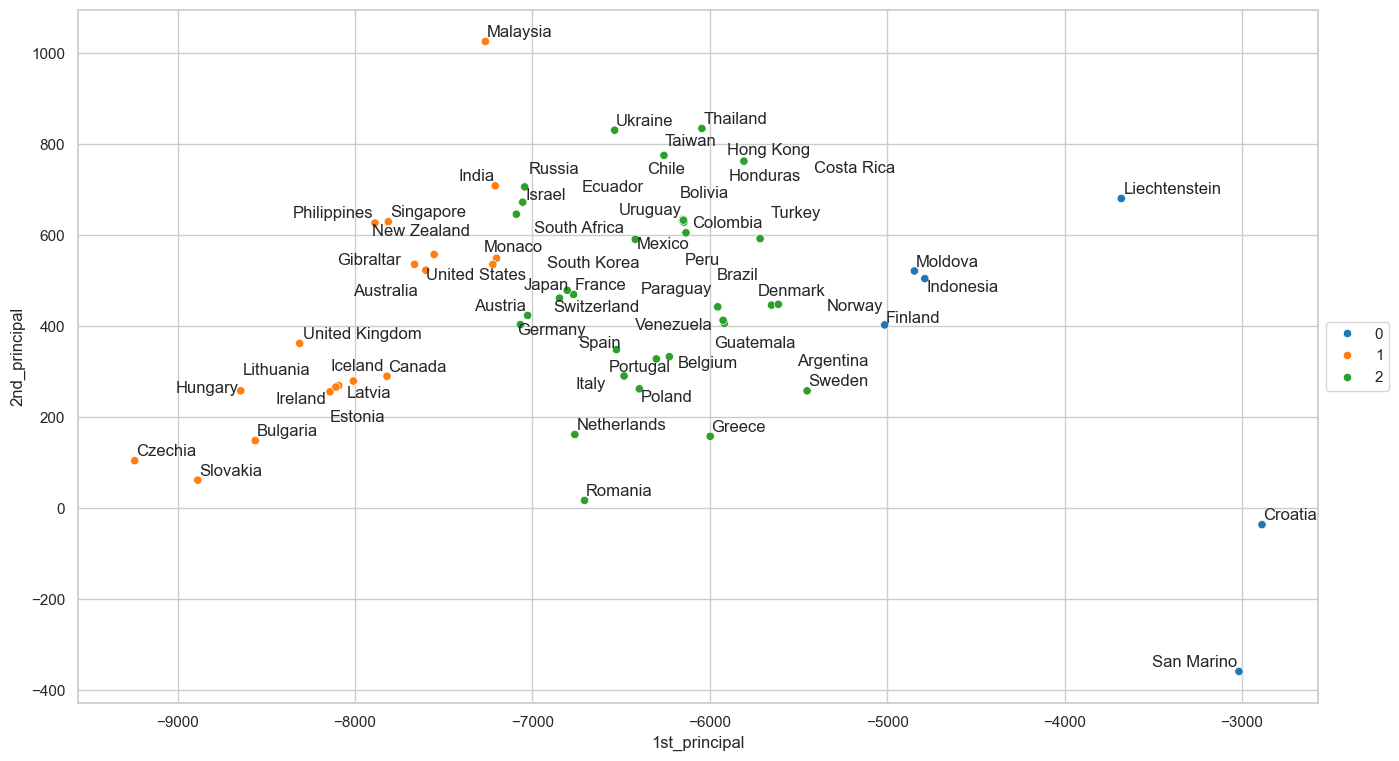

In [7]:
plot_clustering(data, predictions)

# Gaussian Mixture Model (GMM) Clustering

In [8]:
from pyspark.ml.clustering import GaussianMixture

# Train GMM model
gmm = GaussianMixture(k=num_clusters, seed=1)
model = gmm.fit(data)

# make predictions on the test data
predictions = model.transform(data)

In [9]:
for i in range(num_clusters):
    print("Cluster",i)
    c = predictions.filter(F.col("prediction")== i).select("Country").rdd.map(tuple).map(lambda x: x[0]).collect()
    print(c)

Cluster 0
['Croatia', 'Norway', 'San Marino']
Cluster 1
['Argentina', 'Australia', 'Austria', 'Belgium', 'Bolivia', 'Brazil', 'Bulgaria', 'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Czechia', 'Ecuador', 'Estonia', 'Finland', 'France', 'Germany', 'Gibraltar', 'Greece', 'Guatemala', 'Honduras', 'Hong Kong', 'Hungary', 'Iceland', 'Indonesia', 'Ireland', 'Israel', 'Italy', 'Japan', 'Latvia', 'Liechtenstein', 'Lithuania', 'Malaysia', 'Mexico', 'Moldova', 'Monaco', 'Netherlands', 'New Zealand', 'Paraguay', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia', 'Singapore', 'Slovakia', 'South Korea', 'Spain', 'Switzerland', 'Taiwan', 'Thailand', 'Turkey', 'Ukraine', 'United Kingdom', 'United States', 'Uruguay', 'Venezuela']
Cluster 2
['Denmark', 'India', 'South Africa', 'Sweden']


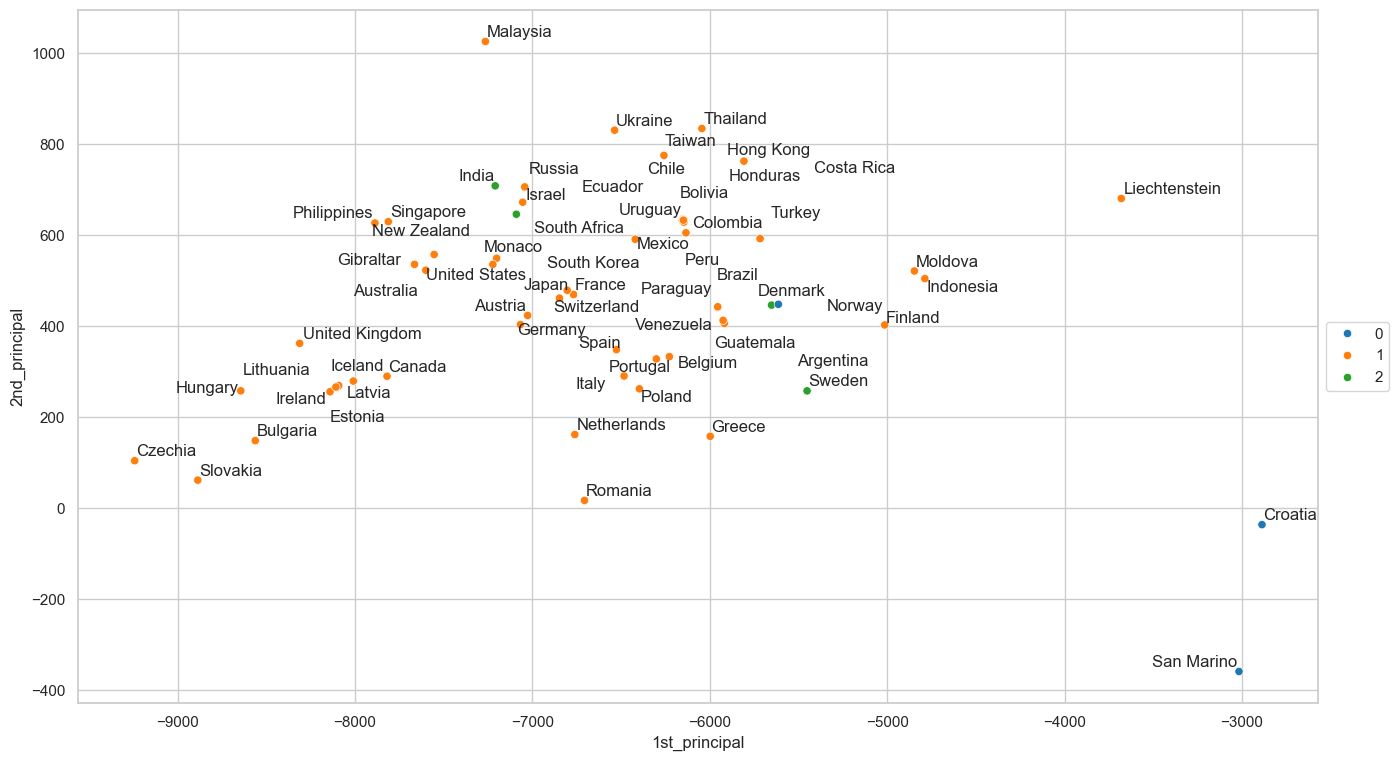

In [10]:
plot_clustering(data, predictions)

# Hierarchical Clustering
## Bisecting K-Means
Bisecting K-Means is a specialized variant of the K-Means clustering algorithm, adapted to create a hierarchical cluster structure. The algorithm starts with one large cluster containing all data points and iteratively bisects the clusters using standard K-Means. 

This process continues until a predetermined number of $k$ leaf clusters are achieved or no clusters are left that can be divided further. 

The algorithm has been particularly optimized for parallel computation in PySpark's BisectingKMeans class, where bisecting steps for clusters at the same hierarchical level are grouped to enhance parallelism. If the bisecting process could potentially create more than $k$ leaf clusters, the algorithm gives priority to bisecting larger clusters.

Cluster 0
['Argentina', 'Australia', 'Denmark', 'Finland', 'France', 'Gibraltar', 'Guatemala', 'Japan', 'Monaco', 'New Zealand', 'Norway', 'Paraguay', 'Philippines', 'Singapore', 'South Africa', 'South Korea', 'Switzerland', 'United States', 'Venezuela']
Cluster 1
['Bolivia', 'Brazil', 'Chile', 'Colombia', 'Costa Rica', 'Ecuador', 'Honduras', 'Hong Kong', 'India', 'Indonesia', 'Israel', 'Liechtenstein', 'Malaysia', 'Mexico', 'Moldova', 'Peru', 'Russia', 'Taiwan', 'Thailand', 'Turkey', 'Ukraine', 'Uruguay']
Cluster 2
['Austria', 'Belgium', 'Bulgaria', 'Canada', 'Croatia', 'Czechia', 'Estonia', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'San Marino', 'Slovakia', 'Spain', 'Sweden', 'United Kingdom']


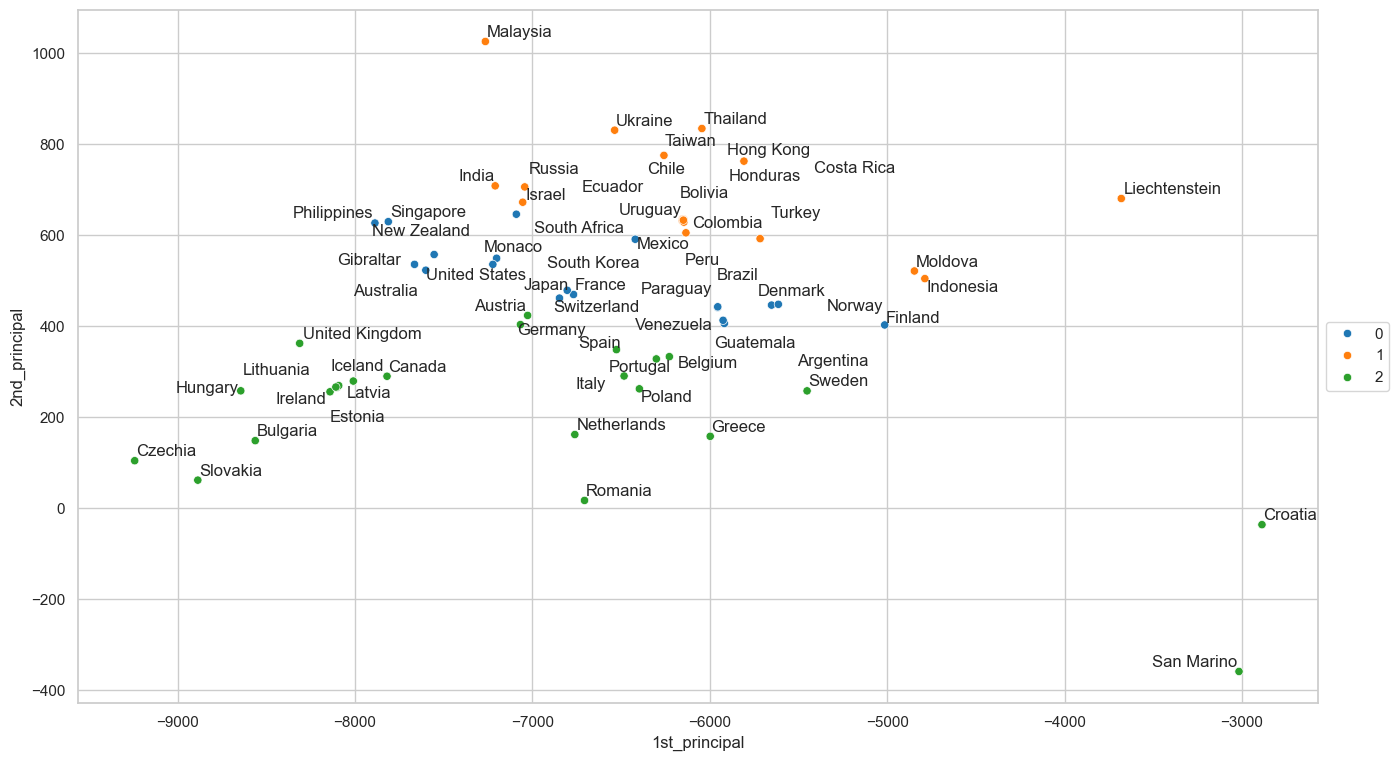

In [10]:
from pyspark.ml.clustering import BisectingKMeans
bkm =BisectingKMeans(featuresCol='features', k=3, distanceMeasure="cosine") 
model=bkm.fit(data)
predictions=model.transform(data)
for i in range(num_clusters):
    print("Cluster",i)
    c = predictions.filter(F.col("prediction")== i).select("Country").rdd.map(tuple).map(lambda x: x[0]).collect()
    print(c)
plot_clustering(data,predictions)